In [2]:
import os
import skmisc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import gzip
from matplotlib.pyplot import rc_context
import anndata as ad  # Importa anndata
import numpy as np
import scanpy as sc
sc.set_figure_params(dpi=100)

In [3]:
import scvi

In [25]:
# Cargar los datos
adata= sc.read_h5ad("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/adata_conTCR_GEX_firmas.h5ad")
adata

AnnData object with n_obs × n_vars = 49718 × 23209
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL', 'ATLAS_TIL_score'
    layers: 'counts_soupx_crude', 'original_counts'

In [23]:
# Limpieza de espacios en blanco y caracteres especiales
adata.obs['ATLAS_TIL'] = adata.obs['ATLAS_TIL'].astype(str).str.strip()  # Eliminar espacios
adata.obs['ATLAS_TIL'] = adata.obs['ATLAS_TIL'].replace('nan', 'unlabeled')  # Convertir NaN a 'unlabeled'

# Verificar categorías únicas después de limpiar
print("Categorías únicas en ATLAS_TIL:", adata.obs['ATLAS_TIL'].unique())

Categorías únicas en ATLAS_TIL: ['CD8.CM' 'CD4.Tfh' 'CD4.Treg' 'CD4.NaiveLike' 'CD8.TEX' 'CD4.CTL_Exh'
 'CD4.CTL_GNLY' 'CD4.CTL_EOMES' 'unlabeled' 'CD8.EM' 'CD8.NaiveLike'
 'CD8.MAIT' 'CD8.TPEX' 'CD8.TEMRA' 'CD4.Th17']


In [24]:
# Guardar el AnnData limpio en el mismo archivo
adata.write("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/adata_conTCR_GEX_firmas.h5ad")

In [6]:
import numpy as np

# Verificar si adata.X es igual a alguna de las capas
if 'counts_soupx_crude' in adata.layers:
    is_crude_soupx = np.array_equal(adata.X.toarray(), adata.layers['counts_soupx_crude'].toarray())
    print("¿adata.X es counts_soupx_crude?:", is_crude_soupx)

if 'original_counts' in adata.layers:
    is_original_counts = np.array_equal(adata.X.toarray(), adata.layers['original_counts'].toarray())
    print("¿adata.X es original_counts?:", is_original_counts)


¿adata.X es counts_soupx_crude?: True
¿adata.X es original_counts?: False


INTEGRAMOS CON SCANVI SABIENDO LA ANOTACIÓN DE LAS CÉLULAS:

In [12]:
!sbatch /data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Scripts/scripts_complementarios/scvi_modelo_params_recomend.sh

Submitted batch job 849696


In [26]:
model_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/modelos/mod_scvi_all_genes_recommended_10pt_conTCR/vae_model"
model = scvi.model.SCVI.load(model_path)

INFO     File                                                                                                      
         /data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/modelos/mod_scvi_all_genes_recommend
         ed_10pt_conTCR/vae_model/model.pt already downloaded                                                      


/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/evercher/miniforge3/envs/scvi-env/lib/python3. ...
/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to 

In [31]:
# Cargar el AnnData asociado
adata = model.adata

In [32]:
# Obtener la representación latente (embedding de scVI)
adata.obsm["X_scVI"] = model.get_latent_representation()

# Confirmar dimensiones del embedding
print(f"Espacio latente de scVI: {adata.obsm['X_scVI'].shape}")

In [33]:
# Normalización basada en scVI (reconstrucción de cuentas normalizadas)
adata.layers["scVI_normalized"] = model.get_normalized_expression()

In [38]:
# Ajustar parámetros para un UMAP más "suave"
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=30)  # Más contexto global
sc.tl.umap(adata, min_dist=0.3, spread=1.2)               # Clústeres más definidos y separados

/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Catego

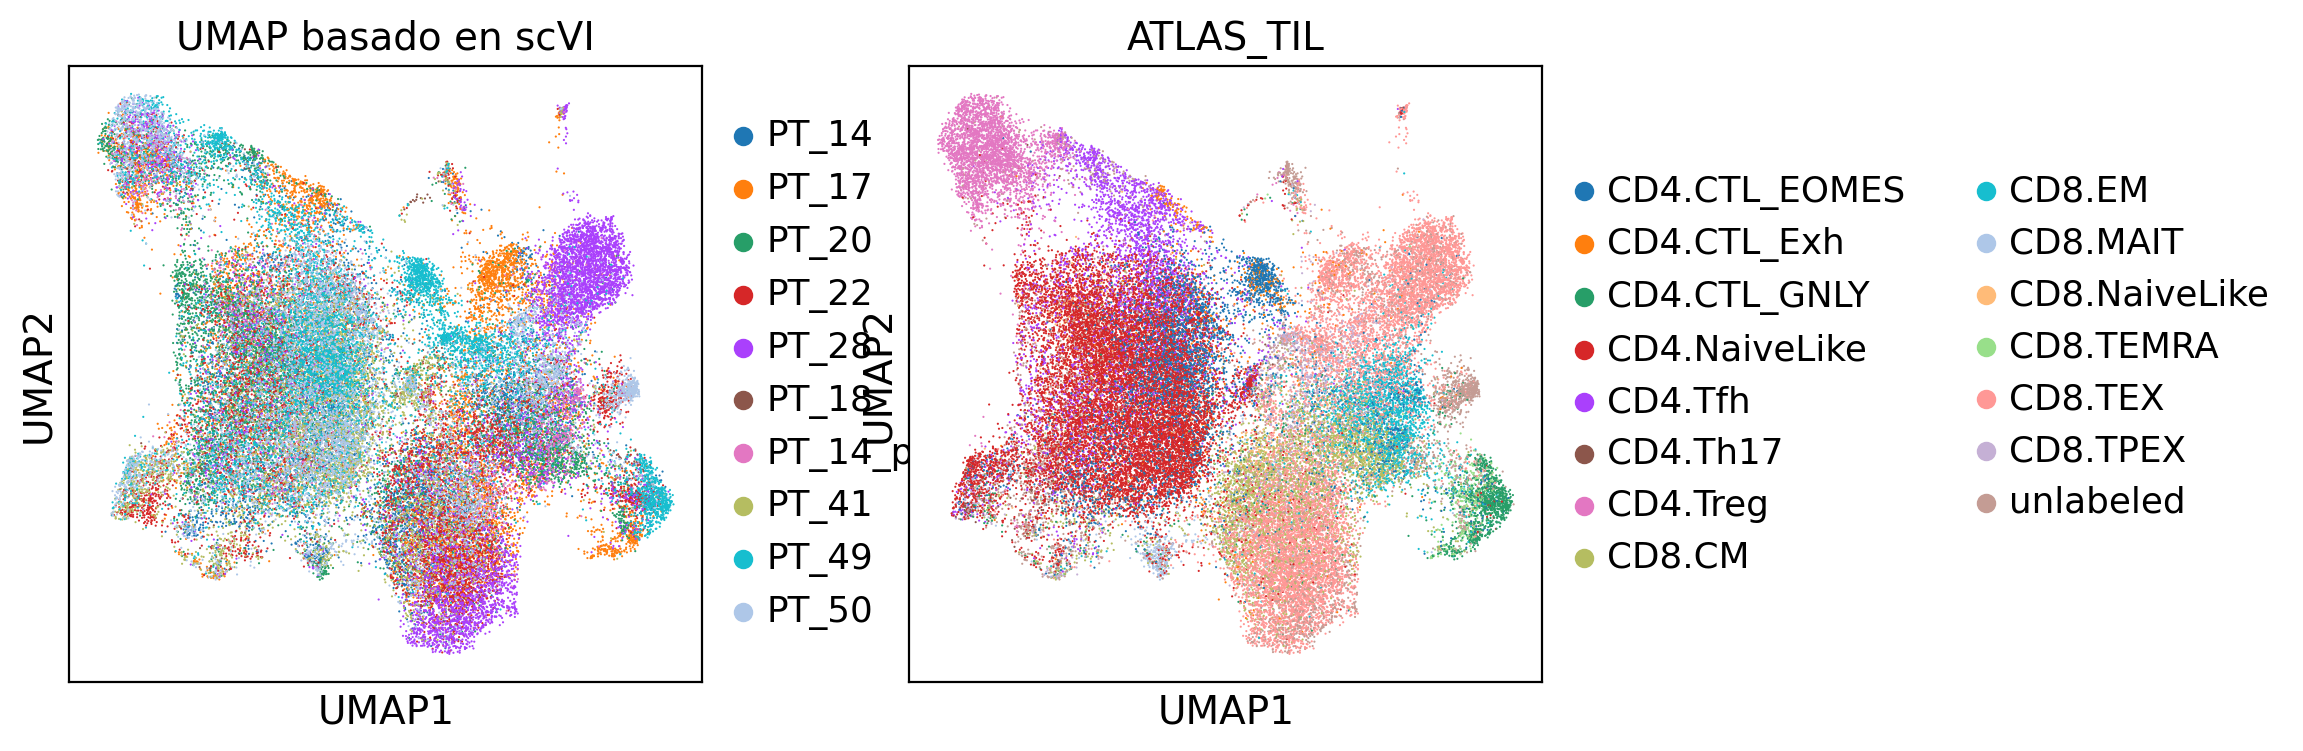

In [39]:
# Visualización inicial para verificar
sc.pl.umap(adata, color=["Sample", "ATLAS_TIL"], title="UMAP basado en scVI")

In [40]:
# Guardar el AnnData integrado para su uso en PopV
output_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/adata_scVI_10pt_conTCR.h5ad"
adata.write(output_path)

print(f"AnnData integrado guardado en: {output_path}")

AnnData integrado guardado en: /data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/adata_scVI_10pt_conTCR.h5ad


In [27]:
# -----------------------------------------------------------------------------
# 2. Ver todas las claves disponibles en el historial
# -----------------------------------------------------------------------------
print("Claves en model.history:")
for k in model.history.keys():
    print(" -", k)

Claves en model.history:
 - kl_weight
 - train_loss_step
 - validation_loss
 - elbo_validation
 - reconstruction_loss_validation
 - kl_local_validation
 - kl_global_validation
 - train_loss_epoch
 - elbo_train
 - reconstruction_loss_train
 - kl_local_train
 - kl_global_train


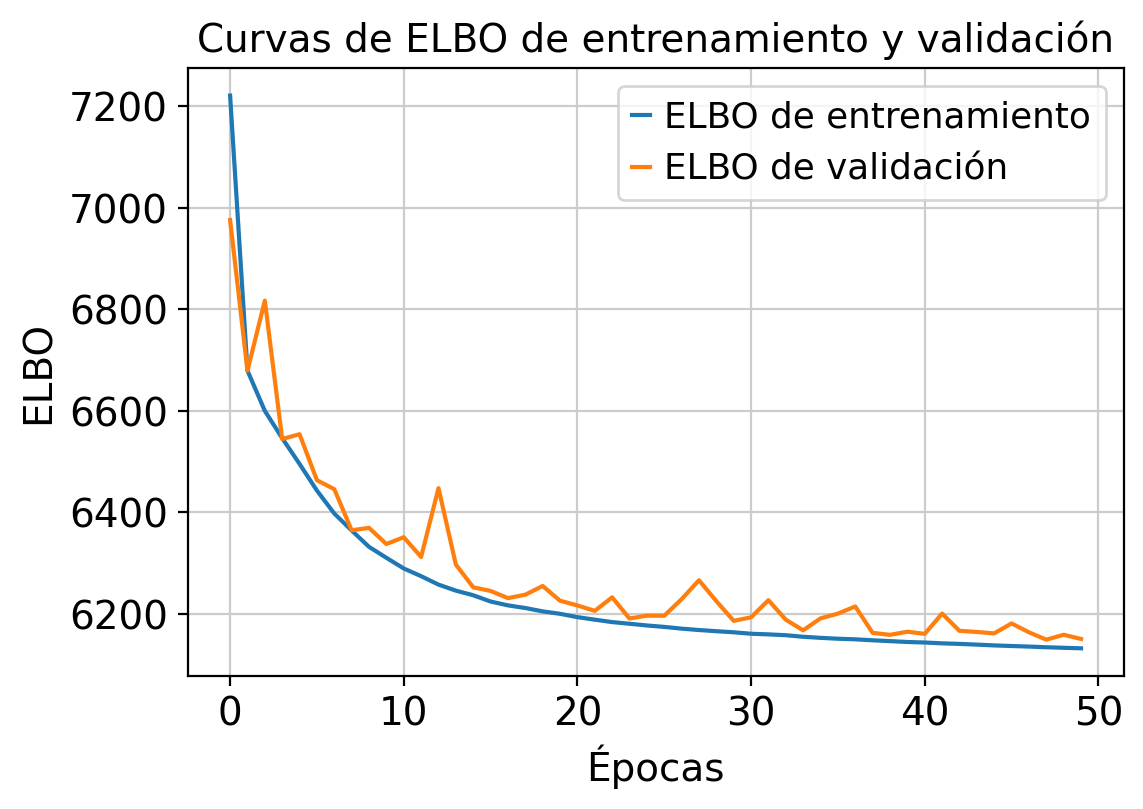

In [28]:
# -----------------------------------------------------------------------------
# 3. Graficar la evolución de la ELBO (Train vs. Validation)
# -----------------------------------------------------------------------------
if 'elbo_train' in model.history and 'elbo_validation' in model.history:
    elbo_train = model.history["elbo_train"]
    elbo_val = model.history["elbo_validation"]

    plt.figure(figsize=(6, 4))
    plt.plot(elbo_train, label="ELBO de entrenamiento")
    plt.plot(elbo_val, label="ELBO de validación")
    plt.xlabel("Épocas")
    plt.ylabel("ELBO")
    plt.title("Curvas de ELBO de entrenamiento y validación")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No se encontraron las claves 'elbo_train' o 'elbo_validation' en model.history")


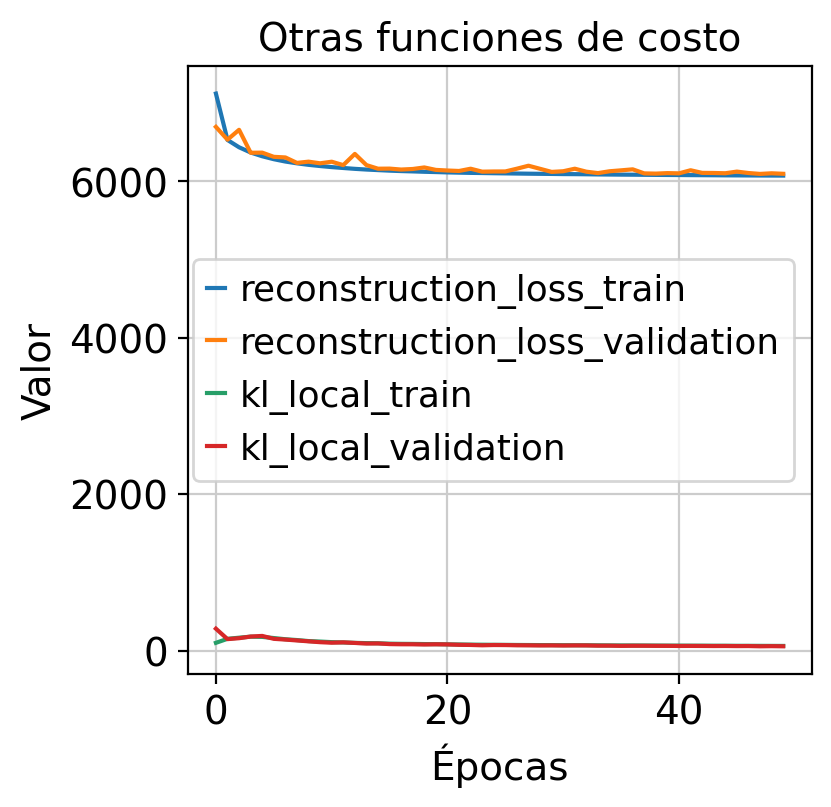

In [29]:
# -----------------------------------------------------------------------------
# 4. Graficar otras funciones de costo (reconstruction_loss, kl_local, etc.)
# -----------------------------------------------------------------------------
# Verifica si existen en model.history:
loss_keys = [
    "reconstruction_loss_train",
    "reconstruction_loss_validation",
    "kl_local_train",
    "kl_local_validation",
]
for key in loss_keys:
    if key in model.history:
        plt.plot(model.history[key], label=key)

if any(k in model.history for k in loss_keys):
    plt.xlabel("Épocas")
    plt.ylabel("Valor")
    plt.title("Otras funciones de costo")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No se encontraron funciones de costo adicionales en model.history")

Vamos a usar scANVI para rellenar el 8% de células que no pudieron ser etiquetadas con el ATLAS. Todas las células tienen TCR y el ATLAS es de TILS, con lo que a priori nos hemos quitado NKs, linfocitos B y células sin TCR.

In [30]:
!sbatch /data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Scripts/scripts_complementarios/scANVI_10pt_ATLAS_projecTIL.sh

/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Submitted batch job 850015


In [41]:
model_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/modelos/mod_sANVI_all_genes_recommended_10pt_conTCR"
scanvi_model = scvi.model.SCANVI.load(model_path)


INFO     File                                                                                                      
         /data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/modelos/mod_sANVI_all_genes_recommen
         ded_10pt_conTCR/model.pt already downloaded                                                               


/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/evercher/miniforge3/envs/scvi-env/lib/python3. ...
/home/evercher/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to 

In [15]:
# Ver todas las claves disponibles:
print("Claves en scanvi_model.history:")
for k in scanvi_model.history.keys():
    print(" -", k)


Claves en scanvi_model.history:
 - train_loss_step
 - validation_loss
 - elbo_validation
 - reconstruction_loss_validation
 - kl_local_validation
 - kl_global_validation
 - validation_classification_loss
 - validation_accuracy
 - validation_f1_score
 - validation_calibration_error
 - train_loss_epoch
 - elbo_train
 - reconstruction_loss_train
 - kl_local_train
 - kl_global_train
 - train_classification_loss
 - train_accuracy
 - train_f1_score
 - train_calibration_error


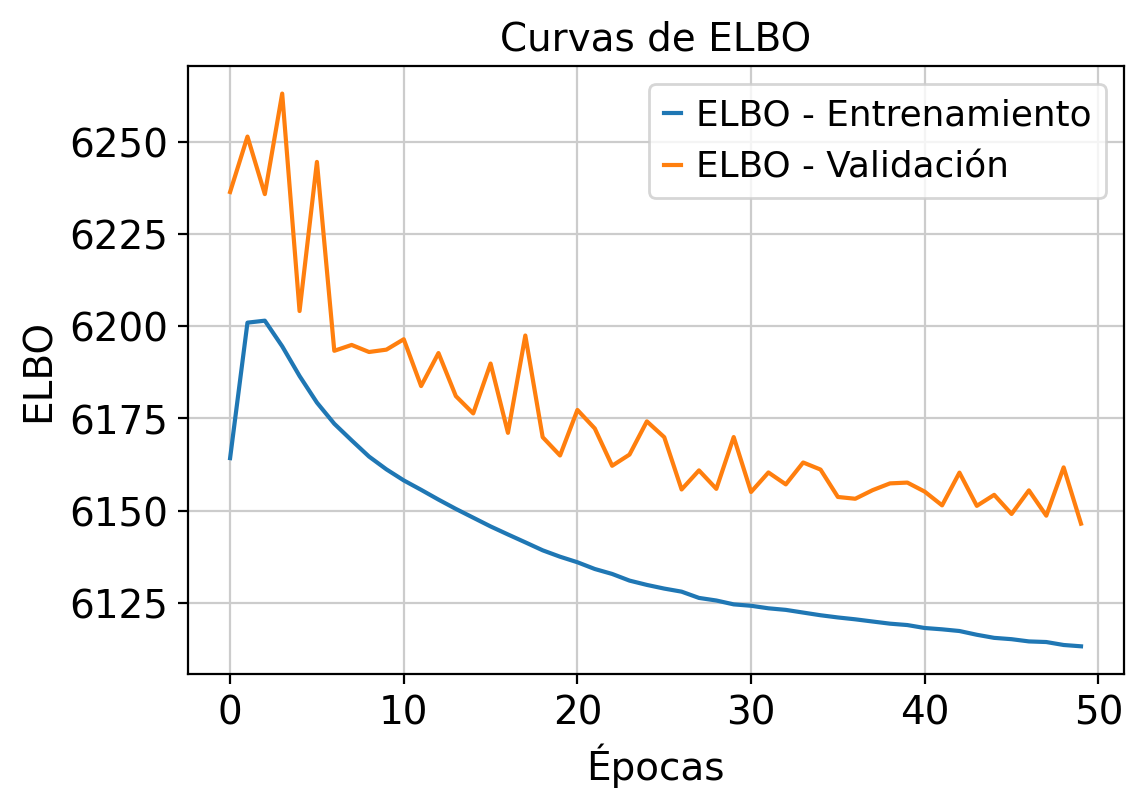

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(scanvi_model.history["elbo_train"], label="ELBO - Entrenamiento")
plt.plot(scanvi_model.history["elbo_validation"], label="ELBO - Validación")
plt.xlabel("Épocas")
plt.ylabel("ELBO")
plt.title("Curvas de ELBO")
plt.legend()
plt.grid(True)
plt.show()


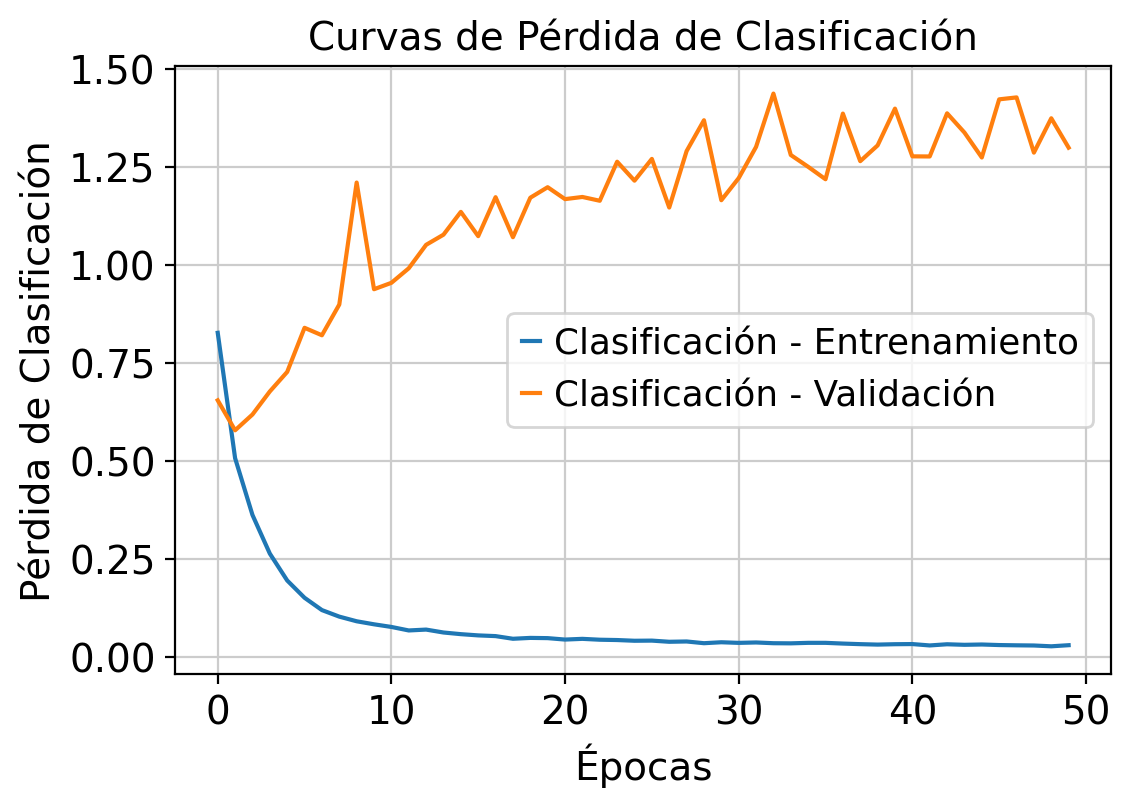

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(scanvi_model.history["train_classification_loss"], label="Clasificación - Entrenamiento")
plt.plot(scanvi_model.history["validation_classification_loss"], label="Clasificación - Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida de Clasificación")
plt.title("Curvas de Pérdida de Clasificación")
plt.legend()
plt.grid(True)
plt.show()

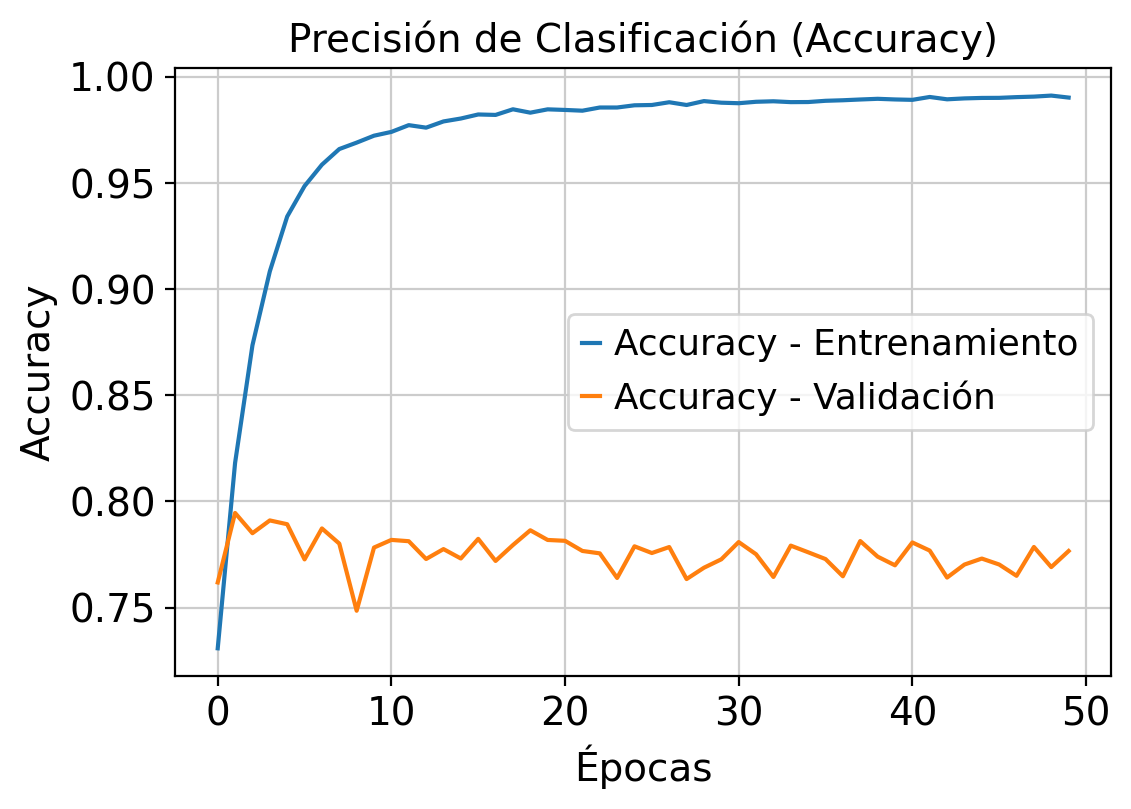

In [44]:
plt.figure(figsize=(6, 4))
plt.plot(scanvi_model.history["train_accuracy"], label="Accuracy - Entrenamiento")
plt.plot(scanvi_model.history["validation_accuracy"], label="Accuracy - Validación")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Precisión de Clasificación (Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


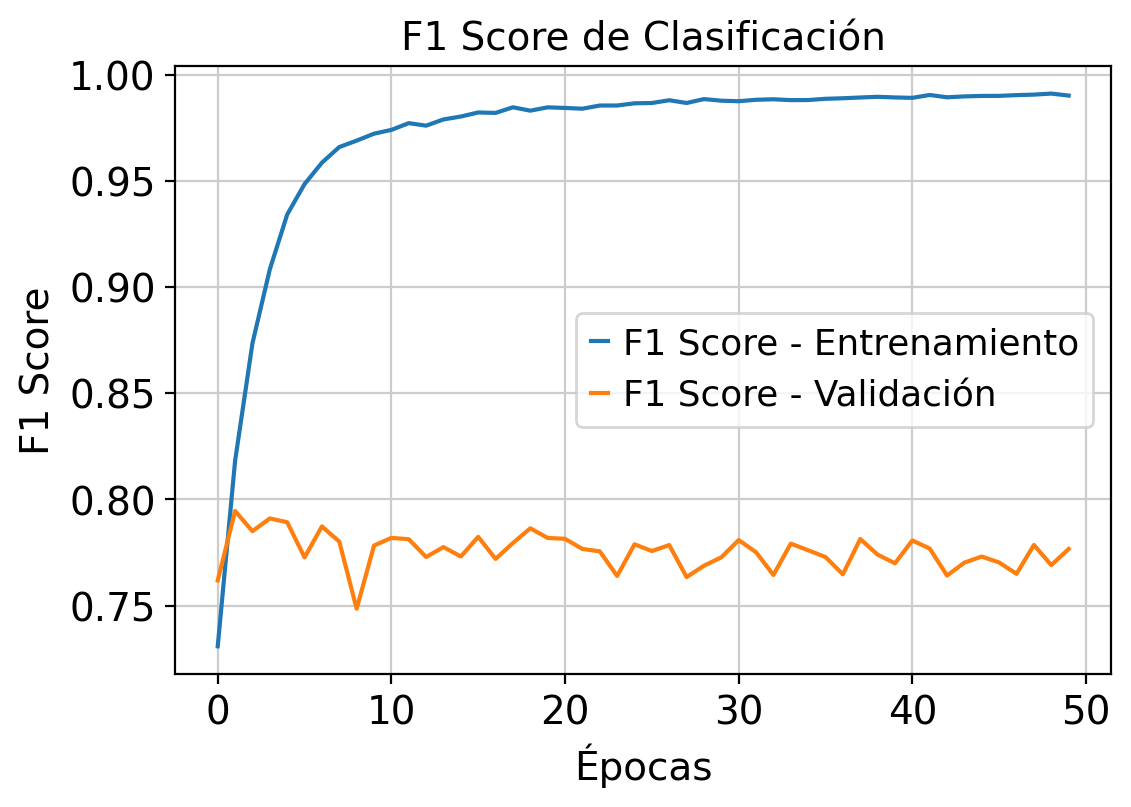

In [45]:
plt.figure(figsize=(6, 4))
plt.plot(scanvi_model.history["train_f1_score"], label="F1 Score - Entrenamiento")
plt.plot(scanvi_model.history["validation_f1_score"], label="F1 Score - Validación")
plt.xlabel("Épocas")
plt.ylabel("F1 Score")
plt.title("F1 Score de Clasificación")
plt.legend()
plt.grid(True)
plt.show()


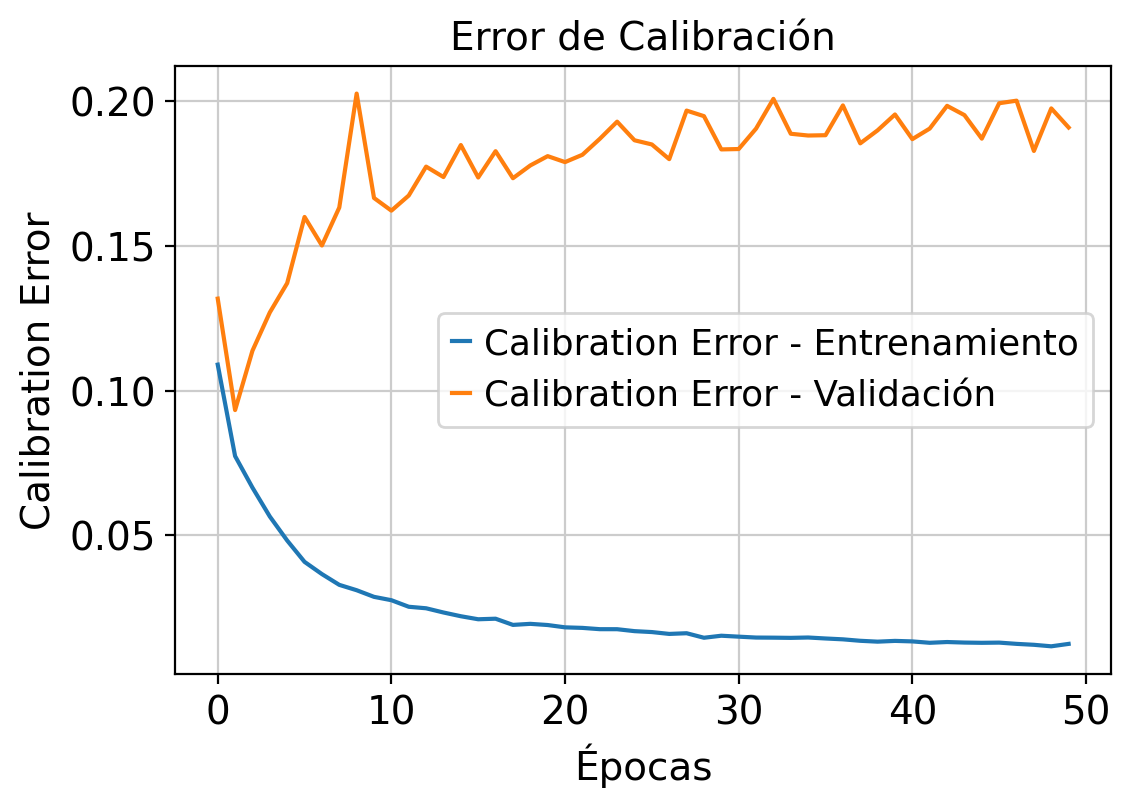

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(scanvi_model.history["train_calibration_error"], label="Calibration Error - Entrenamiento")
plt.plot(scanvi_model.history["validation_calibration_error"], label="Calibration Error - Validación")
plt.xlabel("Épocas")
plt.ylabel("Calibration Error")
plt.title("Error de Calibración")
plt.legend()
plt.grid(True)
plt.show()

#### NO VAMOS A SEGUIR ESTÁ MUY MAL HECHO EL MODELO MUY OVERFITTED

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

In [ ]:

sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["ATLAS_TIL", "C_scANVI"])

In [ ]:
sc.pl.umap(adata_celltypist_TIL, color=["C_scANVI"])
sc.pl.umap(adata_celltypist_TIL, color=["Sample"])

## INTEGRAREMOS FINALMENTE CON HARMONY UNA VEZ OBTENGAMOS LOS DATOS GEX + VDJ (notebook 06)